# LOGIC LEARNING WITH NEURAL NETWORK

Import the libraries and generate synthetic data.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
tf.config.set_visible_devices([], 'GPU')  # Disable GPU for strict reproducibility


# Set random seed for reproducibility
np.random.seed(42)

x1 = np.random.rand(10000, 1) * 10 - 5  # 100 random points in the range [-5, 5]
x2 = np.random.rand(10000, 1) * 10 - 5  # 100 random points in the range [-5, 5]

Create the binary output according to the logic functions.

In [ ]:
y_and = np.logical_and(x1 > 0, x2 > 0).astype(int)  # Logical AND condition
y_or = np.logical_or(x1 > 0, x2 > 0).astype(int)    # Logical OR condition
y_xor = np.logical_xor(x1 > 0, x2 > 0).astype(int)  # Logical XOR condition

Generate the train/test sets.

In [3]:
df = pd.DataFrame({
    "x1": x1.flatten(),
    "x2": x2.flatten(),
    "AND": y_and.flatten(),
    "OR": y_or.flatten(),
    "XOR": y_xor.flatten()
})


train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train[['x1', 'x2']].values
y_train = train[['AND', 'OR', 'XOR']]
X_test = test[['x1', 'x2']].values
y_test = test[['AND', 'OR', 'XOR']]

In [4]:
def create_model():
    """Create a simple neural network model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, activation='relu', input_shape=(2,), name='hidden_layer'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def plot_nn_graph(logic_function, weights_input_hidden=None, bias_hidden=None, weights_hidden_output=None, bias_output=None):
    """
    Visualizes the neural network architecture with weights and biases.
    If weights and biases are not provided, it only shows the architecture.
    """
    G = nx.DiGraph()

    if weights_input_hidden is None or bias_hidden is None or weights_hidden_output is None or bias_output is None:
        architecture_only = True
    else:
        architecture_only = False

    # Define the nodes
    G.add_nodes_from(['Input 1', 'Input 2', 'Hidden Neuron 1', 'Hidden Neuron 2', 'Output'])

    # Define the positions of the nodes
    pos = {
        'Input 1': (0, 1),
        'Input 2': (0, 0),
        'Hidden Neuron 1': (1, 1),
        'Hidden Neuron 2': (1, 0),
        'Output': (2, 0.5)
    }

    if architecture_only:
        # Add edges without weights
        G.add_edges_from([
            ('Input 1', 'Hidden Neuron 1'),
            ('Input 1', 'Hidden Neuron 2'),
            ('Input 2', 'Hidden Neuron 1'),
            ('Input 2', 'Hidden Neuron 2'),
            ('Hidden Neuron 1', 'Output'),
            ('Hidden Neuron 2', 'Output')
        ])
    
    else:
        # Add edges with weight labels and bias labels
        edge_labels = {
            ('Input 1', 'Hidden Neuron 1'): f"{weights_input_hidden[0][0]:.2f}",
            ('Input 1', 'Hidden Neuron 2'): f"{weights_input_hidden[1][0]:.2f}",
            ('Input 2', 'Hidden Neuron 1'): f"{weights_input_hidden[0][1]:.2f}",
            ('Input 2', 'Hidden Neuron 2'): f"{weights_input_hidden[1][1]:.2f}",
            ('Hidden Neuron 1', 'Output'): f"{weights_hidden_output[0]:.2f}",
            ('Hidden Neuron 2', 'Output'): f"{weights_hidden_output[1]:.2f}",
        }
        
        G.add_edges_from(edge_labels.keys())

        bias_labels = {
            'Hidden Neuron 1': f"b={bias_hidden[0]:.2f}",
            'Hidden Neuron 2': f"b={bias_hidden[1]:.2f}",
            'Output': f"b={bias_output:.2f}"
        }

        # Bias label positions (slightly offset vertically)
        bias_pos = {
            k: (v[0], v[1] - 0.07) for k, v in pos.items()
        }

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')
    
    if not architecture_only:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.6)
        nx.draw_networkx_labels(G, bias_pos, labels=bias_labels, font_color='darkgreen', font_size=8, verticalalignment='top')

    
    activation_labels = {
        'Hidden Neuron 1': '\nReLU',
        'Hidden Neuron 2': '\nReLU',
        'Output': '\nSigmoid'
    }
    nx.draw_networkx_labels(G, pos, labels=activation_labels, font_color='blue', font_size=8, verticalalignment='top')

    if architecture_only:
        plt.title('Neural Network Architecture')
    else:
        plt.title(f'Neural Network with Weights and Biases for {logic_function} ')
    plt.show()



def plot_decision_boundary(model, X, y, logic_function_name):
    """Plot the decision boundary and data points"""
    # Create a mesh grid for plotting decision boundary
    h = 0.1  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    
    # Make predictions on the mesh
    mesh_points = np.column_stack([xx.ravel(), yy.ravel()])
    Z = model.predict(mesh_points, verbose=0)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Prediction Probability')
    # Plot decision boundary line (0.5 threshold)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', alpha=0.8)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundary of {logic_function_name}\n (Red: 0, Blue: 1)')
    plt.show()



def plot_activation_space(model, X, y, logic_function_name):
    """
    Visualizes the hidden layer's activation space using t-SNE.
    """
    hidden_layer_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer('hidden_layer').output)
    hidden_activations = hidden_layer_model.predict(X, verbose=0)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1), n_iter=1000)
    X_tsne = tsne.fit_transform(hidden_activations)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.RdBu, s=20)
    plt.title(f't-SNE of Hidden Layer Activations for {logic_function_name}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



In [ ]:
def extract_weights_biases(logic_function, results):
    """
    Extracts weights and biases for the specified logic function from the results DataFrame.
    """
    results_logic = results[results['Logic Function'] == logic_function]
    hidden_weights = results_logic[['Weight (Hidden Layer neuron 1)', 'Weight (Hidden Layer neuron 2)']].values.flatten()
    hidden_biases = results_logic[['Bias (Hidden Layer neuron 1)', 'Bias (Hidden Layer neuron 2)']].values.flatten()
    return hidden_weights, hidden_biases, results_logic['Weight (Output Layer)'].values[0], results_logic['Bias (Output Layer)'].values[0]


### Neural Network Architecture

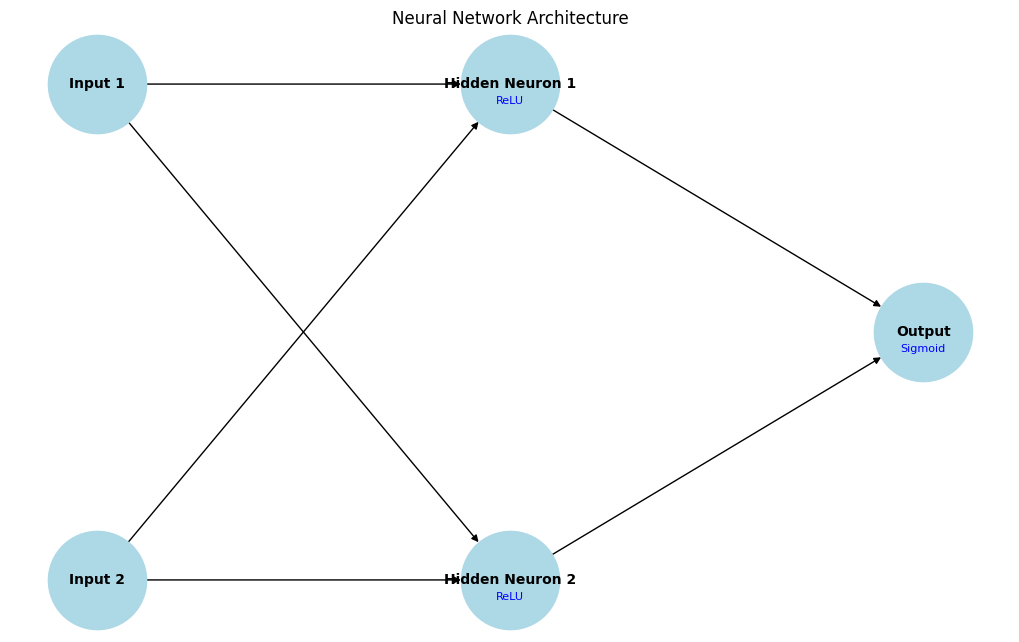

In [ ]:
plot_nn_graph('')

### Train and Evaluate the different Logic Function Models

Training model for AND...
Class weights for AND: {0: 0.6658897952388879, 1: 2.007024586051179}
Evaluating model for AND...
Test Accuracy for AND: 0.9985

Visualizing learned representations for AND...


C:\Users\usuario\AppData\Local\Temp\ipykernel_26420\4008020259.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


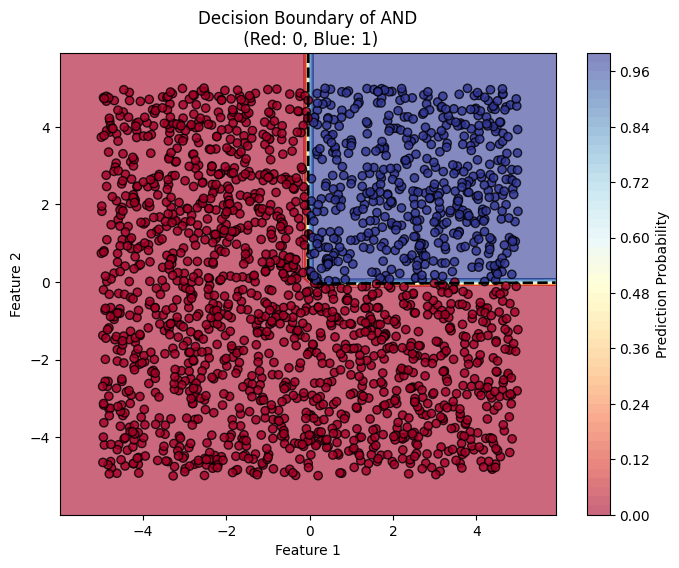

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


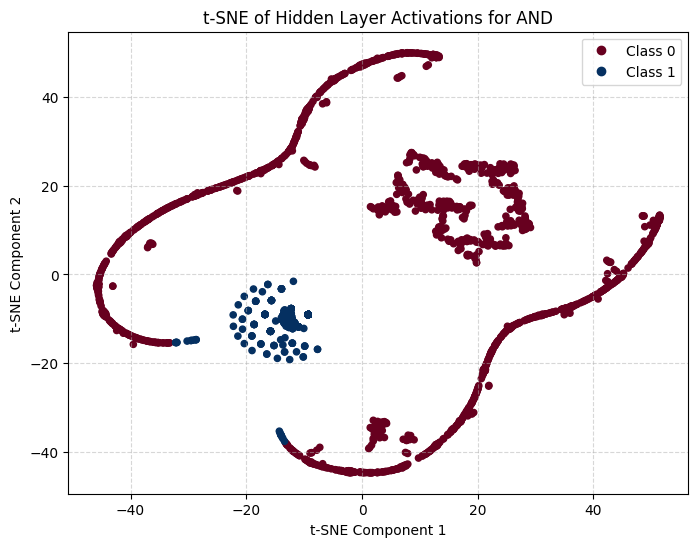

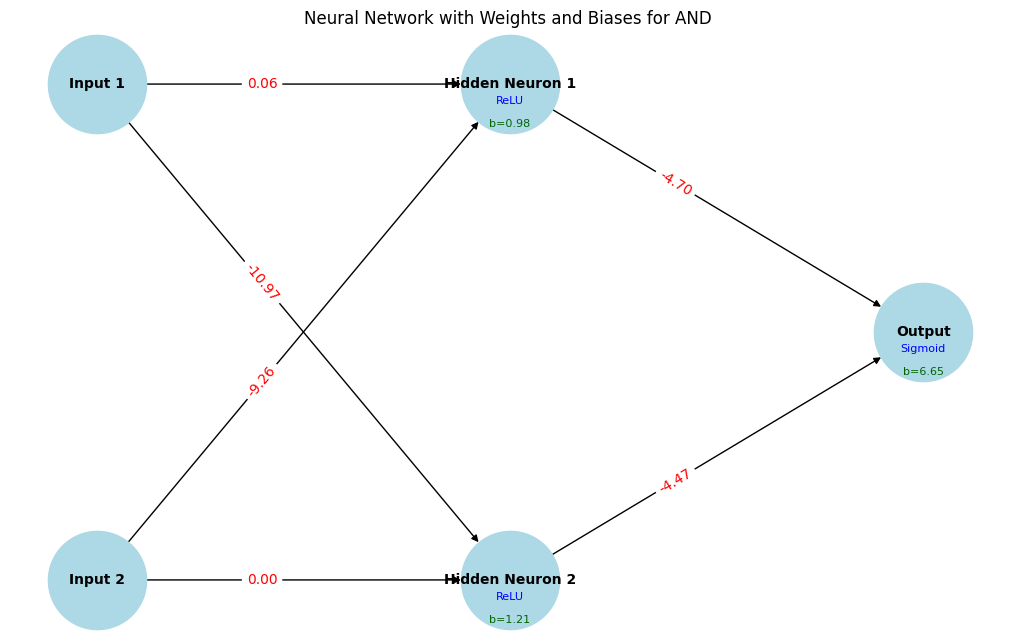

Training model for OR...
Class weights for OR: {0: 1.9656019656019657, 1: 0.6705783738474435}
Evaluating model for OR...
Test Accuracy for OR: 0.9915

Visualizing learned representations for OR...


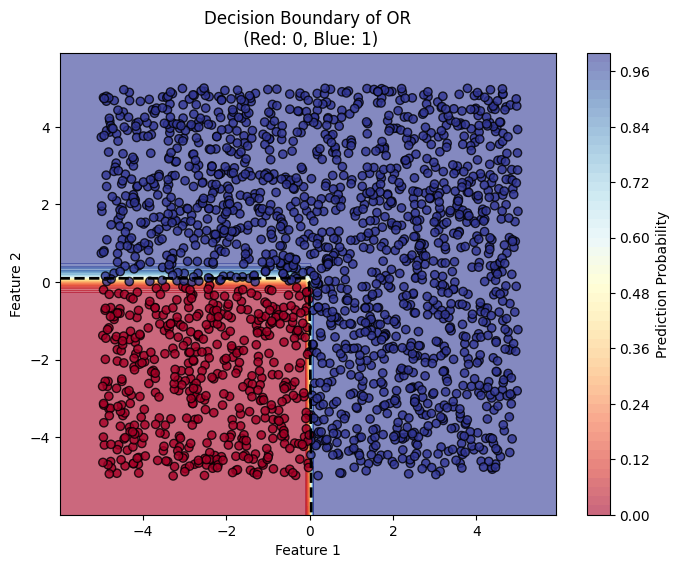

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


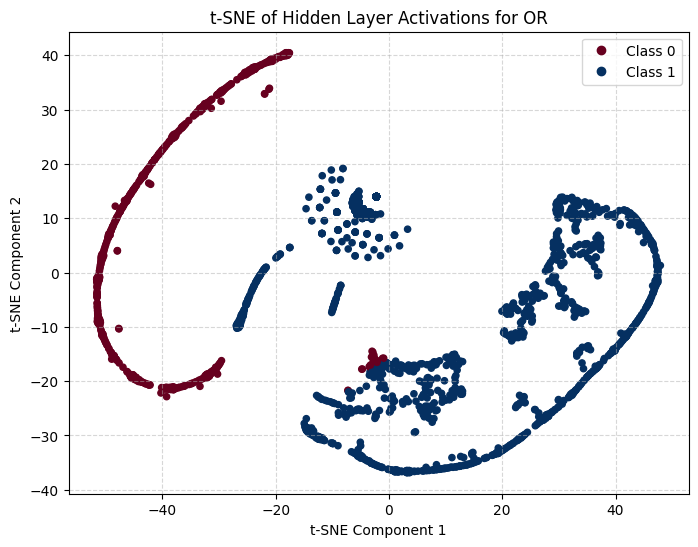

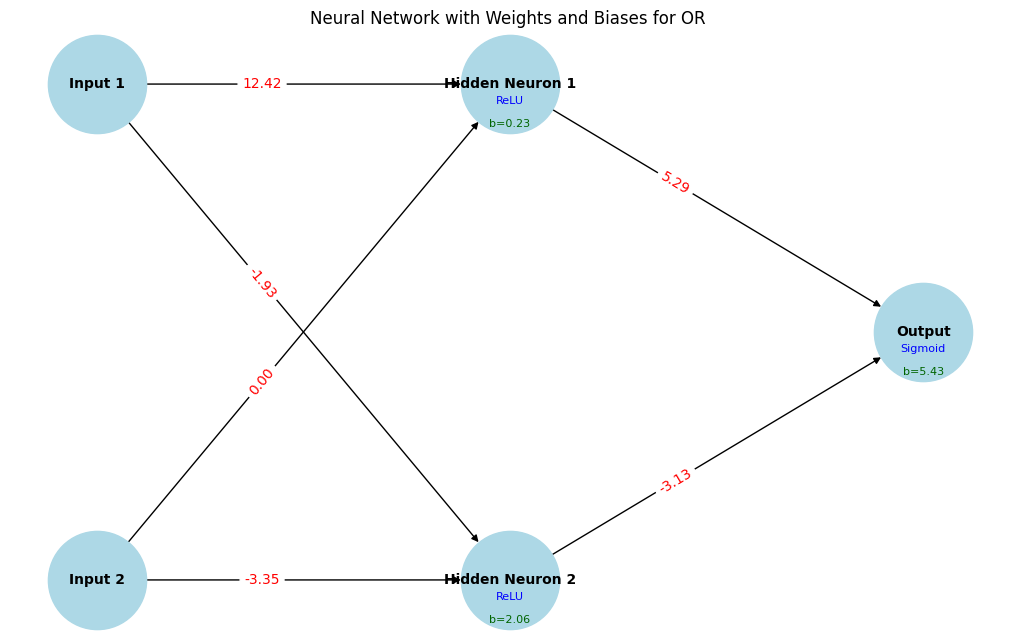

Training model for XOR...
Class weights for XOR: {0: 0.9930486593843099, 1: 1.0070493454179255}
Evaluating model for XOR...
Test Accuracy for XOR: 0.8365

Visualizing learned representations for XOR...


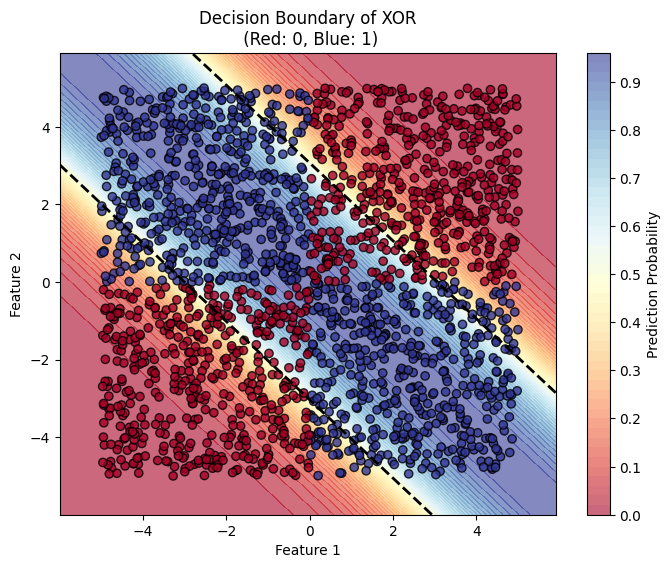

c:\Users\usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


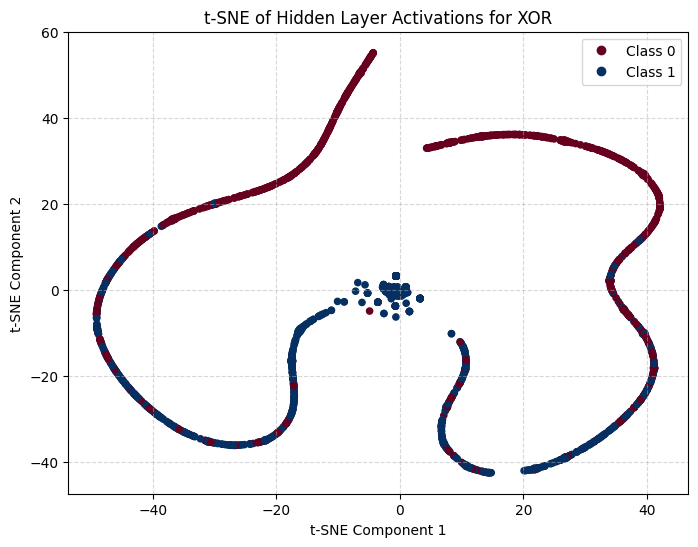

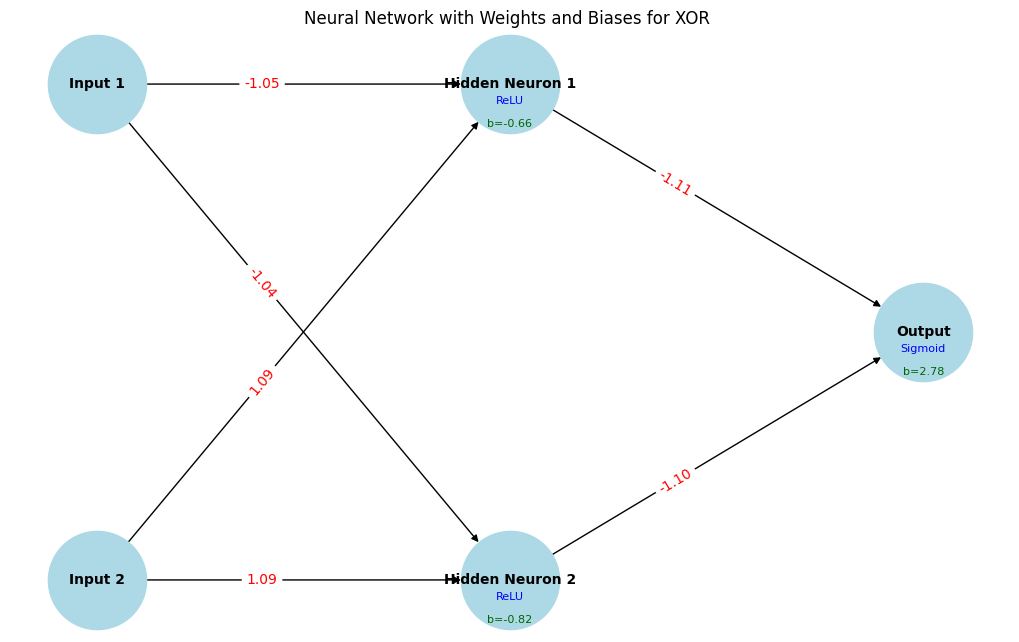

In [8]:
results = pd.DataFrame(columns=[
    'Logic Function', 'Train Accuracy', 'Train Loss', 'Test Accuracy', 'Test Loss',
    'Weight (Hidden Layer neuron 1)', 'Bias (Hidden Layer neuron 1)',
    'Weight (Hidden Layer neuron 2)', 'Bias (Hidden Layer neuron 2)',
    'Weight (Output Layer)', 'Bias (Output Layer)'
])

np.random.seed(42)
tf.random.set_seed(42)
for label, value in y_train.items():
    print(f"Training model for {label}...")

    pos = y_train[value == 1].shape[0]
    neg = len(value) - pos
    class_weight = {0: len(value)/(2*neg), 1: len(value)/(2*pos)}
    print(f"Class weights for {label}: {class_weight}")

    model = create_model()
    model.fit(X_train, value, epochs=100, class_weight=class_weight, verbose=0)
    print(f"Evaluating model for {label}...")
    train_loss, train_accuracy = model.evaluate(X_train, value, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test[label], verbose=0)
    print(f"Test Accuracy for {label}: {test_accuracy:.4f}")

    new_row = {
        'Logic Function': label,
        'Train Accuracy': train_accuracy,
        'Train Loss': train_loss,
        'Test Accuracy': test_accuracy,
        'Test Loss': test_loss,
        'Weight (Hidden Layer neuron 1)': model.layers[0].get_weights()[0][0].tolist(),
        'Bias (Hidden Layer neuron 1)': model.layers[0].get_weights()[1][0],
        'Weight (Hidden Layer neuron 2)': model.layers[0].get_weights()[0][1].tolist(),
        'Bias (Hidden Layer neuron 2)': model.layers[0].get_weights()[1][1],
        'Weight (Output Layer)': model.layers[1].get_weights()[0].flatten().tolist(),
        'Bias (Output Layer)': model.layers[1].get_weights()[1][0]
    }

    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

    print(f"\nVisualizing learned representations for {label.upper()}...")
    plot_decision_boundary(model, X_test, y_test[label], label.upper())
    plot_activation_space(model, X_test, y_test[label], label.upper())
    
    # Extract weights and plot the network graph
    h_w, h_b, o_w, o_b = extract_weights_biases(label, results)
    plot_nn_graph(label.upper(), h_w, h_b, o_w, o_b)

In [9]:
print("\nFinal Results:")
results


Final Results:


,Logic Function,Train Accuracy,Train Loss,Test Accuracy,Test Loss,Weight (Hidden Layer neuron 1),Bias (Hidden Layer neuron 1),Weight (Hidden Layer neuron 2),Bias (Hidden Layer neuron 2),Weight (Output Layer),Bias (Output Layer)
0,AND,0.997875,0.005019,0.9985,0.004369,"[0.05870621278882027, -9.263907432556152]",0.981165,"[-10.973751068115234, 0.004631430841982365]",1.206468,"[-4.7022528648376465, -4.469583988189697]",6.650605
1,OR,0.994875,0.012954,0.9915,0.016291,"[12.416457176208496, 0.001989333890378475]",0.231158,"[-1.9345043897628784, -3.34912371635437]",2.059468,"[5.28599214553833, -3.1275246143341064]",5.433569
2,XOR,0.828750,0.365435,0.8365,0.358839,"[-1.0515583753585815, 1.0948761701583862]",-0.662658,"[-1.041729211807251, 1.0919960737228394]",-0.816982,"[-1.111628770828247, -1.1005196571350098]",2.781185


Save the results into CSV file.

In [10]:
results.to_csv('logic_learning_results.csv', index=False)